# Loads the processed h5 file and plots data

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys
from scipy import signal as ssig

In [4]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [8]:
runs = ['0023_droplets_10um_4mm', '0031_droplets_10um_4mm', '0034_droplets_10um_4mm']
fluence = [275, 458, 92]
imgs = []
Iqs = []
rs = []
qs = []
i0s = []
nshots = []
for run in runs:
    h5path = '/sf/bernina/data/p17743/res/work/hdf5/run%s.h5'%run
    h5file = h5py.File(h5path,'r')
    imgs.append(h5file['JF7/2D_sum'][:])
    rs.append(h5file['JF7/Q_bins'][:])
    Iqs.append(h5file['JF7/I_Q'][:])
    i0s.append(h5file['JF7/i0'].value)
    qs.append(q_scale(h5file['JF7/Q_bins'][:], detector_distance=0.12))
    nshots.append(h5file['JF7/num_shots'].value)
    print('run%s: %d' % (run, h5file['JF7/num_shots'].value))
    h5file.close()

run0023_droplets_10um_4mm: 9000
run0031_droplets_10um_4mm: 1000
run0034_droplets_10um_4mm: 1000


<IPython.core.display.Javascript object>


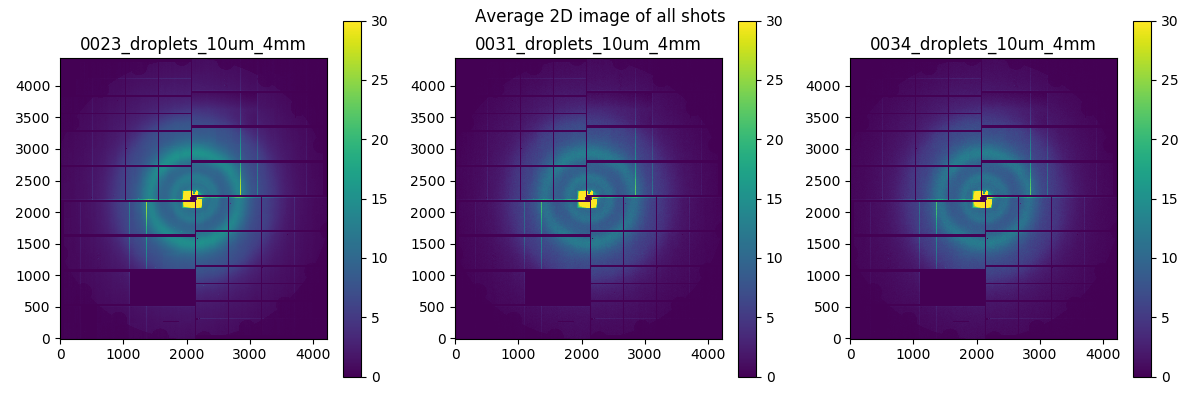

In [19]:
plt.figure(figsize=[12,4])
plt.suptitle('Average 2D image of all shots')
for i in range(len(runs)):
    plt.subplot(1,3,i+1)
    plt.title(runs[i])
    plt.imshow(imgs[i]/nshots[i],clim=[0,30],origin='lower')
    plt.colorbar()
plt.tight_layout()
plt.savefig('fluence_droplets_10um_4mm_2D_images.png')
plt.show()

In [24]:
#normalise
Iq_norm = np.zeros(Iq.shape)
for i in range(1,nshots):
    Iq_norm[i]=Iq[i]#/i0[i]
print(i0)



[  0.           0.4002153    0.63014692 ...,  59.5462265   17.62623405
  76.64690399]


<IPython.core.display.Javascript object>


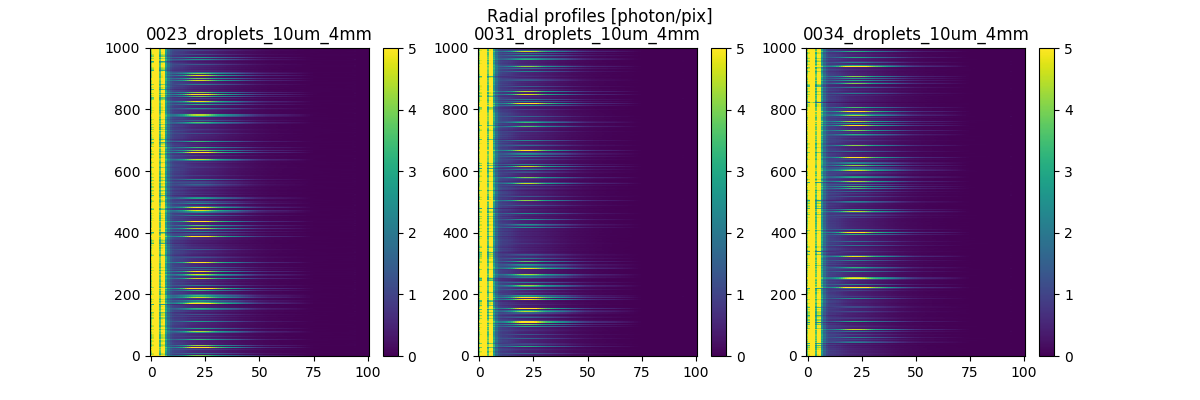

In [22]:
plt.figure(figsize=[12,4])
plt.suptitle('Radial profiles [photon/pix]')
for i in range(len(runs)):
    plt.subplot(1,3,i+1)
    plt.title(runs[i])
    plt.imshow(Iqs[i][:1000]/9.5,aspect='auto',clim=[0,5],origin='lower')
    plt.colorbar()
plt.savefig('fluence_droplets_10um_4mm_radial_profiles.png')
plt.show()

In [30]:
#define hits
iq_threshold = 6
n_shots = 1000
hits = []
iq_metrics = []
for i in range(len(runs)):
    iq_metrics.append(Iqs[i][:n_shots,5:80].mean(axis=1))
    hits.append(iq_metrics[i] > iq_threshold)
    Iqs[i] = Iqs[i][:n_shots]

In [29]:
path = '/sf/bernina/data/p17743/res/scan_info/'
pulse_ids = []
laser_ons = []
from escape.parse import swissfel
for i in range(len(runs)):
    file_path = '%srun%s.json'%(path,runs[i])
    print('-- Loading event data: %s'%file_path)
    data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
    jf7 = data['JF07T32V01'] # JungFrau data
    jf_pulse_id = jf7.eventIds[:n_shots] # event ID at 25 Hz
    evcodes = data['SAR-CVME-TIFALL5:EvtSet'] # trigger codes in 256 channels at 100 Hz
    laser_on = evcodes.data[:,20].compute() # laser trigger at 100 Hz
    pulse_id = evcodes.eventIds # event ID at 100 Hz

    matched_id = np.isin(pulse_id, jf_pulse_id) # matched IDs at 25 Hz in 100 Hz arrays
    assert (np.sum(matched_id) ==  len(jf_pulse_id))
    print('-- Asserting that %d matched IDs sum up to %d JF7 event IDs' % (np.sum(matched_id), len(jf_pulse_id)))
    laser_ons.append(laser_on[matched_id].astype(np.bool)) # laser trigger at 25 Hz)
    pulse_ids.append(jf_pulse_id)


-- Loading event data: /sf/bernina/data/p17743/res/scan_info/run0023_droplets_10um_4mm.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 4
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 4
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 4
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 4
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No e

No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
-- Asserting that 1000 matched IDs sum up to 1000 JF7 event IDs
-- Loading event data: /sf/bernina/data/p17743/res/scan_info/run0034_droplets_10um_4mm.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty datase

In [32]:
def normalize(array, lower_index, upper_index):
    n = np.sum(array[lower_index:upper_index])
    norm_array = array / n
    return norm_array

l = 20
h = 30
hit_avgs = []
miss_avgs = []
off_misses = []
on_misses = []
off_hits = []
on_hits = []
diff_signals = []
diff_errors = []
n_hits_on_off = []
for i in range(len(runs)):
    hit_avgs.append(np.average(Iqs[i][hits[i],:], axis=0)/9.5) # to convert to photon/pix
    miss_avgs.append(np.average(Iqs[i][np.logical_not(hits[i]),:], axis=0)/9.5) # to convert to photon/pix

    off_misses.append(np.average(Iqs[i][np.logical_not(hits[i]) * np.logical_not(laser_ons[i]),:], axis=0))
    on_misses.append(np.average(Iqs[i][np.logical_not(hits[i]) * laser_ons[i],:], axis=0))
    off_hits.append(np.average(Iqs[i][hits[i] * np.logical_not(laser_ons[i]),:], axis=0))
    on_hits.append(np.average(Iqs[i][hits[i] * laser_ons[i],:], axis=0))
    n_hits_on_off.append([(np.logical_not(hits[i]) * np.logical_not(laser_ons[i])).sum(), (np.logical_not(hits[i]) * laser_ons[i]).sum(), np.sum(hits[i] * np.logical_not(laser_ons[i])), np.sum(hits[i] * laser_ons[i])])

    diff_signals.append((normalize(on_hits[i], l, h) - normalize(off_hits[i], l, h))) # / normalize(off_hit, l, h)
    off_hits_1 = np.average(Iqs[i][hits[i] * np.logical_not(laser_ons[i])][:-1:2], axis=0)
    off_hits_2 = np.average(Iqs[i][hits[i] * np.logical_not(laser_ons[i])][1::2], axis=0)
    diff_errors.append(normalize(off_hits_1, l, h) - normalize(off_hits_2, l, h))


<IPython.core.display.Javascript object>


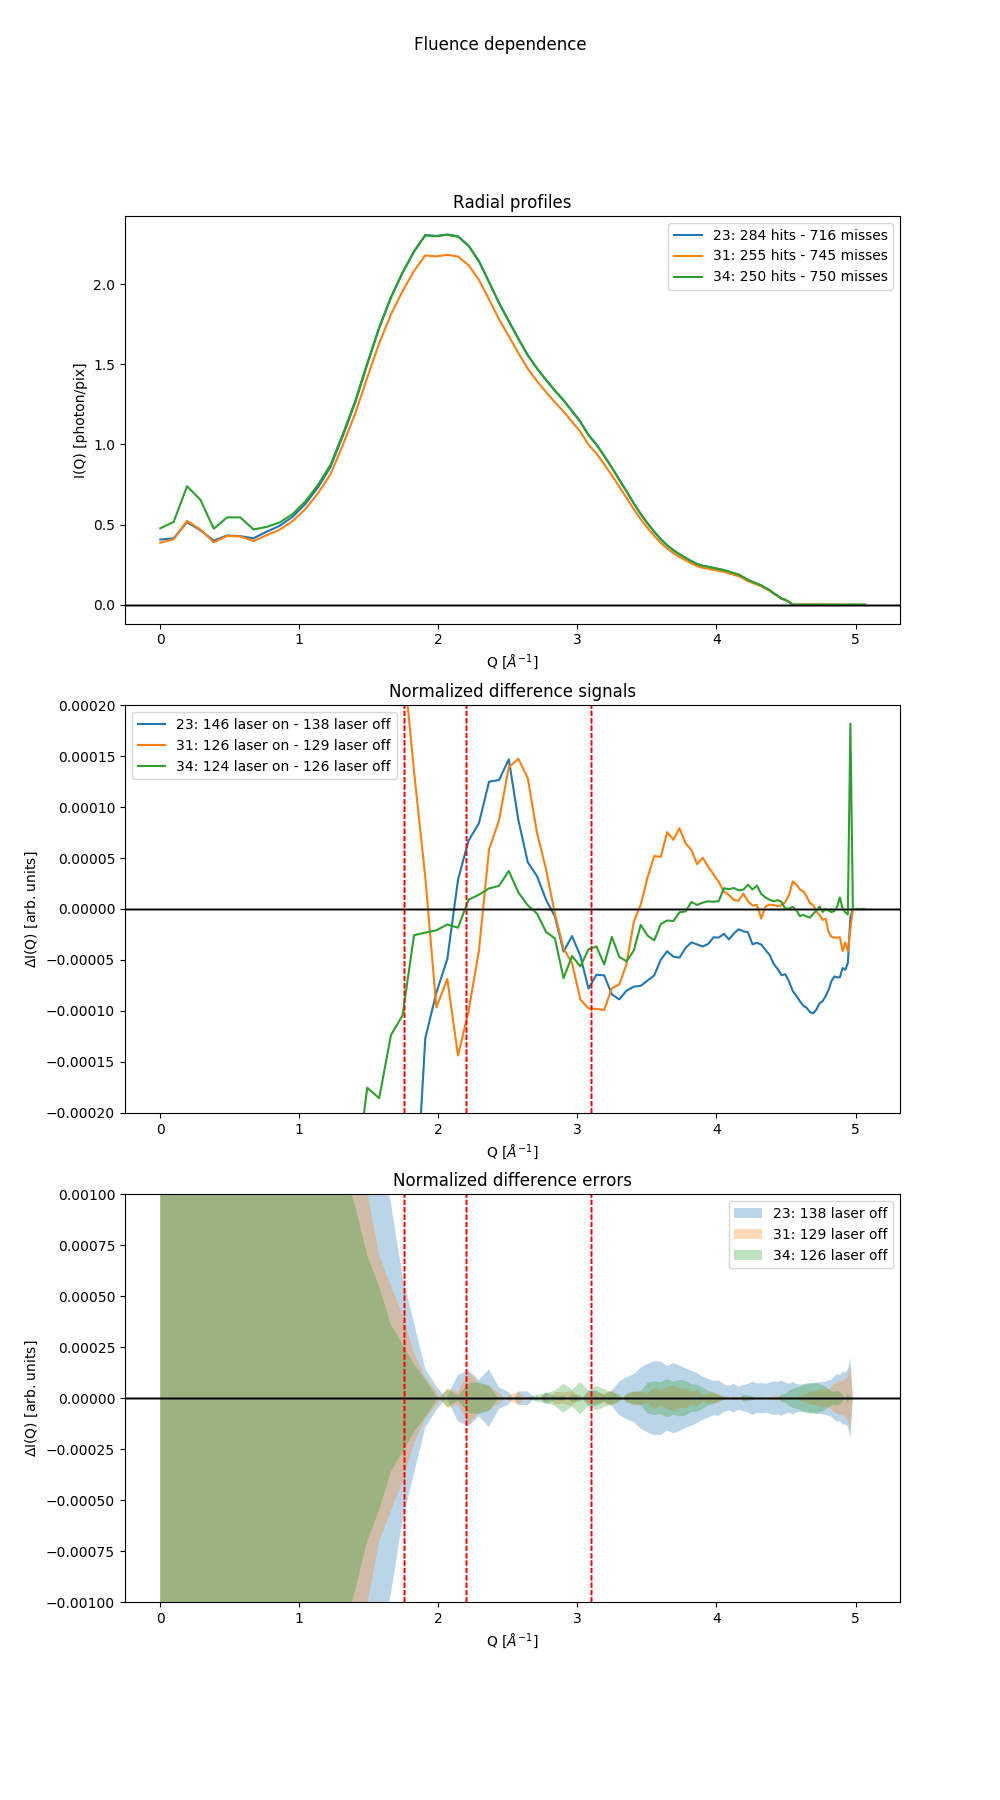

In [50]:
plt.figure(figsize=[10,18])
#plt.figure()
plt.suptitle('Fluence dependence')
for i in range(len(runs)):
    plt.subplot(3,1,1)
    plt.title('Radial profiles')

    plt.plot(qs[i], hit_avgs[i] - miss_avgs[i], label='%s: %d hits - %d misses' % (runs[i][2:4], hits[i].sum(), np.logical_not(hits[i]).sum()))
    plt.xlabel('Q [$\AA^{-1}$]')
    plt.ylabel('I(Q) [photon/pix]')
    plt.legend()
    plt.axhline(0,c='black',lw=1)

    ax = plt.subplot(3,1,2)
    plt.title('Normalized difference signals')
    ax.plot(qs[i], diff_signals[i], label='%s: %d laser on - %d laser off' % (runs[i][2:4], n_hits_on_off[i][3], n_hits_on_off[i][2]))
    #ax.fill_between(q, -off_diff, off_diff, color='grey', alpha=0.3)
    plt.ylabel('$\Delta$I(Q) [arb. units]')
    plt.ylim([-2e-4,2e-4])
    plt.xlabel('Q [$\AA^{-1}$]')
    plt.legend()
    plt.axhline(0,c='black',lw=1)
    plt.axvline(1.75,c='red',lw=1,ls='--')
    plt.axvline(2.2,c='red',lw=1,ls='--')
    plt.axvline(3.1,c='red',lw=1,ls='--')

    ax = plt.subplot(3,1,3)
    plt.title('Normalized difference errors')
    ax.fill_between(qs[i], -diff_errors[i], diff_errors[i], alpha=0.3, label='%s: %d laser off' % (runs[i][2:4], n_hits_on_off[i][2]))
    #ax.fill_between(q, -off_diff, off_diff, color='grey', alpha=0.3)
    plt.ylabel('$\Delta$I(Q) [arb. units]')
    plt.ylim([-10e-4,10e-4])
    plt.xlabel('Q [$\AA^{-1}$]')
    plt.legend()
    plt.axhline(0,c='black',lw=1)
    plt.axvline(1.75,c='red',lw=1,ls='--')
    plt.axvline(2.2,c='red',lw=1,ls='--')
    plt.axvline(3.1,c='red',lw=1,ls='--')

#plt.tight_layout()
plt.savefig('fluence_droplets_10um_4mm_radial_profile_on_off.png')
plt.show()

In [34]:
runs[1][2:4]

'31'

In [45]:
(Iqs[i][hits[i] * np.logical_not(laser_ons[i])][:-1:2]).shape
(Iqs[i][hits[i] * np.logical_not(laser_ons[i])][1::2]).shape

(63, 101)